In [ ]:
from google.colab import drive # run this only on colab
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/Jellyfish/code_and_data/
%ls
!nvidia-smi

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Jellyfish/code_and_data
 bettersplit.py        helper_funcs.py        __pycache__/      task1.ipynb
 cellar/               hsweeptrain_task1.py   randsplit.py      task2.ipynb
 extract_features.py   jellyGPU.ipynb        '#shared_train'/   utils.py
Thu Dec 17 08:07:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   

In [ ]:
import os
import librosa
import numpy as np
import scipy
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers, callbacks


In [ ]:
files_n_classes = np.loadtxt(
    fname= "#shared_train/labels_train.csv",
    delimiter=",",
    dtype='S',
    skiprows=1
).astype(str)

for i in range(len(files_n_classes)):
    files_n_classes[i][0] = files_n_classes[i][0].split('.')[0]

unique_classes, counts = np.unique(files_n_classes[:,1], return_counts=True)

# load train test and dev split saved in the following paths
test_files_n_classes = np.loadtxt("cellar/test_files_n_classes.txt", dtype=str)
train_files_n_classes = np.loadtxt("cellar/train_files_n_classes.txt", dtype=str)
dev_files_n_classes = np.loadtxt("cellar/dev_files_n_classes.txt", dtype=str)


# asign numbers to denote each class and determine class weights
train_labels = np.zeros((len(train_files_n_classes),), int)
test_labels = np.zeros((len(test_files_n_classes),), int)
dev_labels = np.zeros((len(dev_files_n_classes),), int)
for i,c in enumerate(list(unique_classes)):
    train_labels[np.argwhere(train_files_n_classes[:,1] == c)] = i
    test_labels[np.argwhere(test_files_n_classes[:,1] == c)] = i
    dev_labels[np.argwhere(dev_files_n_classes[:,1] == c)] = i


# ref: Logistic Regression in Rare Events Data, King, Zen, 2001
class_weights = len(train_labels) / (len(unique_classes) * np.bincount(train_labels))
weights_dict = {i:w for i,w in enumerate(class_weights)}
print(weights_dict)

{0: 0.8672222222222222, 1: 2.6913793103448276, 2: 0.8672222222222222, 3: 0.8672222222222222, 4: 0.8672222222222222, 5: 0.8869318181818182, 6: 3.122, 7: 0.7095454545454546, 8: 0.9942675159235669, 9: 0.8672222222222222}


# Model

In [ ]:
filter_sizes = [i for i in range(1, 26)]
sif_input = layers.Input((None, 52))
conv_outputs = []
for kernel_size in filter_sizes:
    x = layers.Conv1D(100, kernel_size, activation='relu')(sif_input)
    x = layers.Dropout(0.50)(x)
    x = layers.GlobalMaxPooling1D()(x)
    conv_outputs.append(x)
conv_output = layers.Concatenate()(conv_outputs)
# conv_output = layers.ReLU()(conv_output)
conv_output = layers.Dropout(0.50)(conv_output)
outputs = layers.Dense(len(unique_classes), activation='softmax')(conv_output)

model = Model(inputs= sif_input, outputs= outputs)
model.add_loss(lambda : 0.0001*tf.add_n([tf.nn.l2_loss(w) for w in model.trainable_weights]))
optimizer = optimizers.Adam(lr=0.001, decay=0.01)
model.compile(optimizer= optimizer, 
            loss='categorical_crossentropy', 
            metrics="accuracy")
print("total params: ", model.count_params())

total params:  1717510


## Training the model

### function for extracting features

In [ ]:
def extract_SIF(raw_spec, W=13, frequency_stride=10):
    """
    raw_spec: spectogram of shape (Fbins, time)
    Fbins: number of freq bins
    returns: array of shape (F, time)
    """
    # frequency downsampling into F bins 
    L = raw_spec.shape[0]
    F = (L-W)//frequency_stride + 1
    SIF = np.zeros((F, raw_spec.shape[1]))
    for i in range(F):
        freq_window = raw_spec[i*frequency_stride:i*frequency_stride+W]
        SIF[i][:] = np.mean(freq_window, 0)    
    # denoise
    SIF_dn = SIF - np.min(SIF, axis=0)
    # augment SIF_dn append per frame time tomain energy
    energy_shorttime = np.sum(SIF_dn, axis=0)
    SIF_aug = np.concatenate(
        [SIF_dn, np.expand_dims(energy_shorttime, 0)], axis= 0)

    return SIF_aug

### data generator class

In [ ]:
# the SIF generator for task 1
class task1_SIF_generator():
    def __init__(self, spec_files, labels, batch_size, not_infinite):
        """
        spec_files: filepaths
        labels: one-hot encoding list or np array 
        not_infinite: set True is generator should terminate
        """
        self.count = 0
        self.spec_files = spec_files
        self.maxcount = len(spec_files)
        self.labels = labels
        self.batch_size = batch_size
        self.not_infinite = not_infinite
        self.continue_generation = True

    def make_batch(self):
        self.count = self.count % self.maxcount
        MAX = self.count + self.batch_size

        sifs = []
        batch_labels = []
        max_length = 0
        for i in range(self.count, MAX):

            idx = i % self.maxcount
            batch_labels.append(self.labels[idx])
            raw_spec = np.load(self.spec_files[idx], allow_pickle=True)
            sif = extract_SIF(raw_spec)
            sifs.append(sif)
            max_length = max(max_length, sif.shape[1])

            # terminate for non-infinite
            if self.not_infinite and i >= self.maxcount-1: 
                self.continue_generation = False
                break

        self.count += self.batch_size
        
        for i in range(len(sifs)):
            sif = sifs[i]
            pad_len = max_length - sif.shape[1]
            sifs[i] = np.pad(sif, ((0,0),(0,pad_len))).T

        sifs = np.asarray(sifs, np.float32)
        batch_labels = np.asarray(batch_labels)

        return sifs, batch_labels
        

    def generator(self):
        '''
        files: np Array with file names as byte-strings
        labels: integer labels
        Output: np array of spectrograms, corresponding labels as a list
        '''
        while self.continue_generation:
            yield self.make_batch()

    def reset(self):
        self.count = 0
        self.continue_generation = True


### make the data generators

In [ ]:
batch_size = 64

# data-generator to load and pre-process spectrograms in batches
train_datgenerator = task1_SIF_generator(
    spec_files= [f"cellar/spectograms/{fn}.npy" for fn in train_files_n_classes[:, 0]],
    labels= tf.one_hot(train_labels, len(unique_classes)).numpy(),
    batch_size= batch_size,
    not_infinite= False
)

dev_datgenerator = task1_SIF_generator(
    spec_files= [f"cellar/spectograms/{fn}.npy" for fn in dev_files_n_classes[:, 0]],
    labels= tf.one_hot(dev_labels, len(unique_classes)).numpy(),
    batch_size= batch_size,
    not_infinite= False
)

train_datgenerator = tf.data.Dataset.from_generator(
    train_datgenerator.generator,
    (tf.float32, tf.int32), 
    output_shapes= (tf.TensorShape((None, None, 52)), tf.TensorShape((None, 10)))
    ).prefetch(tf.data.experimental.AUTOTUNE)

dev_datgenerator = tf.data.Dataset.from_generator(
    dev_datgenerator.generator,
    (tf.float32, tf.int32), 
    output_shapes= (tf.TensorShape((None, None, 52)), tf.TensorShape((None, 10)))
    ).prefetch(tf.data.experimental.AUTOTUNE)
    

In [ ]:
tf_log_num = "2"
if os.path.exists(f"cellar/run/task1/{tf_log_num}/model.save"): 
    print("log dir exists")
    model = tf.keras.models.load_model(f"cellar/run/task1/{tf_log_num}/model.save")
    model.summary()
elif not os.path.exists(f'cellar/run/task1/{tf_log_num}'):
    os.makedirs(f'cellar/run/task1/{tf_log_num}')
    tf.keras.utils.plot_model(model, to_file=f'cellar/run/task1/{tf_log_num}/model.png', show_shapes=True)
    

log dir exists
Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, 52)]   0                                            
__________________________________________________________________________________________________
conv1d_100 (Conv1D)             (None, None, 100)    5300        input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_101 (Conv1D)             (None, None, 100)    10500       input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_102 (Conv1D)             (None, None, 100)    15700       input_3[0][0]                    
________________________________________________________________________

In [ ]:
# training model
model.fit(train_datgenerator,
            validation_data= dev_datgenerator,
            validation_steps= len(dev_files_n_classes)//batch_size,
            epochs=500,
            class_weight= weights_dict,
            steps_per_epoch=len(train_files_n_classes)//batch_size,
            callbacks=[
                callbacks.TensorBoard(log_dir=f'cellar/run/task1/{tf_log_num}/logs', 
                                    histogram_freq=8, write_images=True),
                callbacks.ModelCheckpoint(f"cellar/run/task1/{tf_log_num}/ckeckpoints", 
                                    verbose=1, save_best_only=True),
                callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, verbose=1, min_delta=0.001),
                callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            ]
            )

In [ ]:
# save it
model.save(filepath=f"cellar/run/task1/{tf_log_num}/model.save")

INFO:tensorflow:Assets written to: cellar/run/task1/3/model.save/assets


In [ ]:
# evaluating model
# model = tf.keras.models.load_model(f"cellar/run/task1/{tf_log_num}/model.save")
test_generator = task1_SIF_generator(
    spec_files= [f"cellar/spectograms/{fn}.npy" for fn in test_files_n_classes[:, 0]],
    labels= tf.one_hot(test_labels, len(unique_classes)).numpy(),
    batch_size= 32,
    not_infinite= True
)
dev_generator = task1_SIF_generator(
    spec_files= [f"cellar/spectograms/{fn}.npy" for fn in dev_files_n_classes[:, 0]],
    labels= tf.one_hot(dev_labels, len(unique_classes)).numpy(),
    batch_size= batch_size,
    not_infinite= True
)
model.evaluate(test_generator.generator())
model.evaluate(dev_generator.generator())

2/2 [==============================] - 9s 5s/step - loss: 1.2287 - accuracy: 0.8500


[1.2287181615829468, 0.8500000238418579]

testset


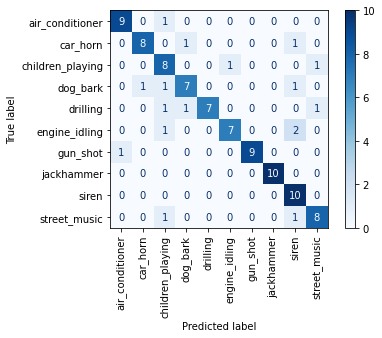

classes             precision    recall    fscore    support
----------------  -----------  --------  --------  ---------
air_conditioner      0.9            0.9  0.9              10
car_horn             0.888889       0.8  0.842105         10
children_playing     0.615385       0.8  0.695652         10
dog_bark             0.777778       0.7  0.736842         10
drilling             1              0.7  0.823529         10
engine_idling        0.875          0.7  0.777778         10
gun_shot             1              0.9  0.947368         10
jackhammer           1              1    1                10
siren                0.666667       1    0.8              10
street_music         0.8            0.8  0.8              10 


devset


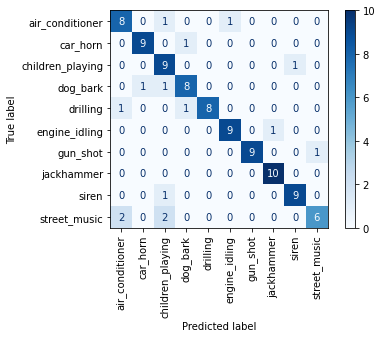

classes             precision    recall    fscore    support
----------------  -----------  --------  --------  ---------
air_conditioner      0.727273       0.8  0.761905         10
car_horn             0.9            0.9  0.9              10
children_playing     0.642857       0.9  0.75             10
dog_bark             0.8            0.8  0.8              10
drilling             1              0.8  0.888889         10
engine_idling        0.9            0.9  0.9              10
gun_shot             1              0.9  0.947368         10
jackhammer           0.909091       1    0.952381         10
siren                0.9            0.9  0.9              10
street_music         0.857143       0.6  0.705882         10 




In [ ]:
# confusion mat
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_fscore_support
from tabulate import tabulate
def plot_conf(data_gen, unique_classes, decl=''):
    print(decl)
    data_gen.reset()
    p = tf.argmax(model.predict(data_gen.generator()), 1)
    data_gen.reset()
    t = tf.argmax(np.concatenate([y for i,y in data_gen.generator()], 0), 1)
    confusion_matrix = tf.math.confusion_matrix(t, p, 10)

    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix.numpy(), display_labels=unique_classes)
    disp.plot(include_values=True, cmap=plt.cm.Blues, ax=None, xticks_rotation="vertical")
    plt.savefig(f"cellar/run/task1/{tf_log_num}/test_confusion_matrix.png", format="png")
    plt.show()

    precision, recall, fbeta_score, support = precision_recall_fscore_support(unique_classes[t], unique_classes[p], labels=unique_classes)
    
    table = []
    for i,c in enumerate(unique_classes):
        table.append([c, precision[i], recall[i], fbeta_score[i], support[i]])
    print(tabulate(table, headers=["classes", "precision", "recall", "fscore", "support"]), "\n\n")

plot_conf(test_generator, unique_classes, "testset")
plot_conf(dev_generator, unique_classes, "devset")

# Predict function for inference

In [ ]:
# make sure you have loaded the model before
unique_classes = np.array(['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music'])
def Predict(spec, unique_classes):
    sif = extract_SIF(spec)
    if sif.shape[1] < 50:
        pad_len = 50 - sif.shape[1]
        sif = np.pad(sif, ((0,0),(0,pad_len)))
    pred = model(tf.expand_dims(sif.T, 0)).numpy()
    return unique_classes[np.argmax(pred)]

# Predict on all spectogram files in the 'test_feat_path' folder

In [ ]:

est_save_path = "task1_labels_test.csv"
# est_save_path = "cellar/temp/task1/est.csv"

test_feat_path= "test_task1/feats"
# test_feat_path= "#shared_train/sample_test_task1/feats"

In [ ]:
# make the predictions and save as a csv file
predictions = []
for f in os.listdir(test_feat_path):
    spec = np.load(f"{test_feat_path}/{f}")
    predictions.append([f.split('.')[0], Predict(spec, unique_classes)])
if not os.path.exists("cellar/temp/task1"): os.makedirs("cellar/temp/task1")
np.savetxt(est_save_path, predictions, delimiter =",",  fmt ='%s') 

# for running on score function from utils

In [ ]:
# !pip install python-Levenshtein

In [ ]:
import utils # the utils.py given for evaluation

In [ ]:
ground_truth_labels_path = "#shared_train/sample_test_task1/labels.csv"

In [ ]:
print("score:", utils.evals(ground_truth_labels_path, est_save_path, 1))
p = utils.read_csv(est_save_path)
t = utils.read_csv(ground_truth_labels_path)
for k in sorted(p.keys()):
    print(f"{k}:", f" pred: ", p[k], "\n", "".join([" "]*len(f"{k}")), " gndt: ", t[k])

score: 0.8
a00001:  pred:  drilling 
         gndt:  drilling
a00002:  pred:  drilling 
         gndt:  drilling
a00003:  pred:  drilling 
         gndt:  drilling
a00004:  pred:  street_music 
         gndt:  street_music
a00005:  pred:  jackhammer 
         gndt:  jackhammer
a00006:  pred:  dog_bark 
         gndt:  dog_bark
a00007:  pred:  children_playing 
         gndt:  children_playing
a00008:  pred:  drilling 
         gndt:  drilling
a00009:  pred:  siren 
         gndt:  engine_idling
a00010:  pred:  engine_idling 
         gndt:  dog_bark
